#### **Welcome to Assignment 5 on Deep Learning for Computer Vision.**
In this assignment you will learn VAE and Normalizing Flow.

#### **Instructions**
1. Use Python 3.x to run this notebook
3. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
4. Read documentation of each function carefully.

## Question 1:

Given an input image $x$ and parameters of an Encoder and Decoder of a Variational AutoEncoder(VAE) , find the variational Lower bound of $p(x)$, i.e. probability of $x$.

Which of the following expressions holds True?

1.   $p(x)$ >= 0.8712
2.   $p(x)$ >= 0.8998
3.   $p(x)$ >= 0.9371
4.   $p(x)$ >= 0.9418


Hint: \begin{aligned} \log p_\theta(x) &\geq \mathbb{E}_{q_\phi(z|x)} \left[ \log p_\theta(x|z) \right] - \text{KL}\left[q_\phi(z|x) || p(z) \right] \end{aligned}
Note: Use torch.exp() library function in order to compute exponential.


Number of samples:  60000
0 0.06928868591785431
1 0.06647869944572449
2 0.06962444633245468
3 0.06681197881698608
4 0.06524046510457993
5 0.06682556867599487
6 0.06271817535161972
7 0.06800952553749084
8 0.0716957226395607
9 0.06784282624721527
10 0.06786999106407166
11 0.0641535297036171
12 0.06696563959121704
13 0.06280635297298431
14 0.0683976486325264
15 0.0670972615480423
16 0.06900014728307724
17 0.06699176877737045
18 0.0650017037987709
19 0.06126606464385986
20 0.06747967004776001
21 0.062186334282159805
22 0.0710962787270546
23 0.07024997472763062
24 0.07056711614131927


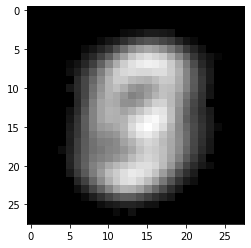

In [ ]:
'''Script to train a Variational AutoEncoder. Note : This Script is given for your reference, Not for
   Evaluation Purpose. You are encouraged to modify different part of the code and see how it affects'''

import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import os
from os.path import join as oj


out_dir = 'samples'
os.makedirs(out_dir, exist_ok=True)

class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r


class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class VAE(torch.nn.Module):
    latent_dim = 8

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, 8)
        self._enc_log_sigma = torch.nn.Linear(100, 8)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)


def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)


if __name__ == '__main__':

    input_dim = 28 * 28
    batch_size = 32

    transform = transforms.Compose(
        [transforms.ToTensor()])
    mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

    dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

    print('Number of samples: ', len(mnist))

    encoder = Encoder(input_dim, 100, 100)
    decoder = Decoder(8, 100, input_dim)
    vae = VAE(encoder, decoder)

    criterion = nn.MSELoss()

    optimizer = optim.Adam(vae.parameters(), lr=0.0001)
    l = None
    
    for epoch in range(25):
        for i, data in enumerate(dataloader, 0):
            inputs, classes = data
            inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes)
            optimizer.zero_grad()
            dec = vae(inputs)
            ll = latent_loss(vae.z_mean, vae.z_sigma)
            loss = criterion(dec, inputs) + ll
            loss.backward()
            optimizer.step()
            l = loss.item()
        print(epoch, l)
    torch.save(vae.state_dict(), oj(out_dir, f'vae_final.pth'))

    plt.imshow(vae(inputs).data[0].numpy().reshape(28, 28), cmap='gray')
    plt.show(block=True)
    

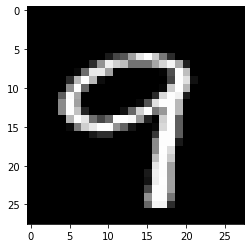

Lower Bound of p(x):  tensor(0.9371, grad_fn=<ExpBackward>)


In [ ]:
# Load a given Pretrained VAE model, and compute lower bound of p(x), given input image x

import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import os
from os.path import join as oj

torch.manual_seed(1)
np.random.seed(1)

out_dir = 'samples'
os.makedirs(out_dir, exist_ok=True)

class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r


class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class VAE(torch.nn.Module):
    latent_dim = 8

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, 8)
        self._enc_log_sigma = torch.nn.Linear(100, 8)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)


def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)


if __name__ == '__main__':

    transform = transforms.Compose(
        [transforms.ToTensor()])
    mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

    dataloader = torch.utils.data.DataLoader(mnist, batch_size=1,
                                             shuffle=True, num_workers=2)
    for input in dataloader:
      im0,_ = input 
      break
    
    # Visualize the input image

    plt.imshow(im0.data[0].numpy().reshape(28, 28), cmap='gray')
    plt.show(block=True)

    ## Find out P(im0) >= ? i.e. Lower bound of Probability of im0
    ### YOUR CODE STARTS HERE ###

    input_dim = 28 * 28

    encoder = Encoder(input_dim, 100, 100)
    decoder = Decoder(8, 100, input_dim)
    vae = VAE(encoder, decoder)

    vae.load_state_dict(torch.load('/content/samples/vae_final.pth'))
    criterion = nn.MSELoss()

    enc = vae.encoder(im0.reshape(-1, 784))
    z = vae._sample_latent(enc)
    recons_im0 = vae.decoder(z)

    ll = latent_loss(vae.z_mean, vae.z_sigma)
    loss = criterion(recons_im0, im0.reshape(-1, 784)) + ll
    print ("Lower Bound of p(x): ", torch.exp(-loss))
    
    ### YOUR CODE ENDS HERE ###
    

## Question 2:

Compute "Transformed" Probability Density Function (pdf) of $\mathbf{y}$, i.e.  $q_1(\mathbf{y})$. Where, $\mathbf{y}$ is obtained from $\mathbf{z}$ via an invertible transformation $f$ as shown below:

Let $\mathbf{z}\sim q_0(\mathbf{z})$ where $q_0(\mathbf{z}) = \mathcal{N}(\mathbf{z};\mathbf{0},\mathbf{I})$.  
Let $f(\mathbf{z})$ be an invertible transformation given by 
$$ \mathbf{y} = f(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^\top\mathbf{z}+b)$$
The pdf of $\mathbf{y}$ is given by
$q_1(\mathbf{y})$

Which of the following are correct about $q_1(\mathbf{y})$; given the values of $q_0(\mathbf{z})$ , $\mathbf{f}$ and all the parameters required to compute $f(\mathbf{z})$?

1.   Mean = 0.0473 ; Std = 0.0636
2.   Mean = 0.0581 ; Std = 0.0527
3.   Mean = 0.0614 ; Std = 0.0491
4.   Mean = 0.0512 ; Std = 0.0561





Hint: 
$$q_1(\mathbf{y}) = q_0(\mathbf{z})\left|\det\frac{\partial f}{\partial \mathbf{z}}\right|^{-1}$$

$\left|\det\frac{\partial f}{\partial \mathbf{z}}\right|$ can be computed as follows
$$ \psi(\mathbf{z}) = h'(\mathbf{w}^\top\mathbf{z}+b)\mathbf{w} $$
$$\left|\det\frac{\partial f}{\partial \mathbf{z}}\right| = |1 + \mathbf{u}^\top\psi(\mathbf{z})|$$
Here, we set $h(x)=\tanh(x)$ which gives us $h'(x)=(1-\tanh^2(x))$

Note: In code "det_J(z)" is used to represent  the following quantity: $$\left|\det\frac{\partial f}{\partial \mathbf{z}}\right|$$

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as LA

np.random.seed(1)

## Define Parameters of Invertible transformation
w = np.array([4., 0])
u = np.array([2., 0])
b = 0

## Define and Instantiate probability Density function q0(z)

def mvn_pdf(X, mu=np.array([[0,0]]), sig=np.eye(2)):
    sqrt_det_2pi_sig = np.sqrt(2 * np.pi * LA.det(sig))
    sig_inv = LA.inv(sig)
    X = X[:, None, :] - mu[None, :, :]
    return np.exp(-np.matmul(np.matmul(X, np.expand_dims(sig_inv, 0)), (X.transpose(0, 2, 1)))/2)/sqrt_det_2pi_sig

r = np.linspace(-3,3,1000)
z = np.array(np.meshgrid(r, r)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
q0 = mvn_pdf(z)


### YOUR CODE STATRS HERE ###

## Functions required to compute q1(y)..

def h(x):
    return np.tanh(x)

def h_prime(x):
    return 1 - np.tanh(x) ** 2

def f(z):
    y = z + np.dot(h(np.dot(z, w) + b).reshape(-1,1), u.reshape(1,-1))
    return y

def det_J(z):
    psi = h_prime(np.dot(z, w) + b).reshape(-1,1) * w
    det = np.abs(1 + np.dot(psi, u.reshape(-1,1)))
    return det

## Actual computation of Transformed Probability Density Function of y , i.e. q1(y).
q1 = q0.squeeze()/det_J(z).squeeze()

### YOUR CODE ENDS HERE ###

print ("Mean of q1(y): ",np.mean(q1))
print ("Standard Deviation of q1(y): ",np.std(q1))

Mean  of q1(y):  0.04737678549050468
Standard Deviation of q1(y):  0.06367172026601238
